In [167]:
# Data handling and processing
import pandas as pd
import numpy as np
import random

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Model evaluation and utilities
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings('ignore', message="is_sparse is deprecated")

# XGBoost
import xgboost as xgb
print(xgb.__version__)

# Progress display
import tqdm

# Statsmodels
import statsmodels.api as sm

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import torchmetrics
from torch.nn import functional as F
from torch.nn import CrossEntropyLoss

# Optuna for hyperparameter optimization
import optuna


2.1.1


In [127]:
def plot_errors(train_losses, val_losses):
    """
    Plots training and validation losses over epochs.
    
    Parameters:
    - train_losses: List of training loss values for each epoch.
    - val_losses: List of validation loss values for each epoch.
    """
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label="Training Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss Over Epochs")
    plt.legend()
    plt.show()


In [128]:
full_data = pd.read_csv('~/data/phasing/NA12878/6finalized/exonPhasedSites_final_matrix_24828_finalized.tsv',sep='\t')
full_data["MAF"] = full_data["EUR_MAF"]
full_data["lag_MAF"] = full_data["lag_EUR_MAF"]
full_data["min_MAF"] = full_data["min_EUR_MAF"]
full_data["diff_MAF"] = full_data["diff_EUR_MAF"]
# make interaction between log10distance and r2
full_data["log10distance_intxn_r2"] = full_data["log10_distance"] * full_data["r2"]
full_data["log10distance_intxn_minMAF"] = full_data["log10_distance"] * full_data["min_MAF"]
full_data["log10distance_intxn_diffMAF"] = full_data["log10_distance"] * full_data["diff_MAF"]
full_data_sub = full_data[["chr", "pos", "geneID", "error", "d", "r2", "AF", "MAF", "lag_MAF", "min_MAF", "diff_MAF", "log10_distance","log10distance_intxn_r2","log10distance_intxn_minMAF","log10distance_intxn_diffMAF"]]

full_data_sub.head()

,chr,pos,geneID,error,d,r2,AF,MAF,lag_MAF,min_MAF,diff_MAF,log10_distance,log10distance_intxn_r2,log10distance_intxn_minMAF,log10distance_intxn_diffMAF
0,chr1,909419,ENSG00000187583,NaN,1.000,0.024,0.111222,0.111222,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,chr1,914852,ENSG00000187642,NaN,0.872,0.334,0.512580,0.487420,0.1839,0.1839,0.2167,NaN,NaN,NaN,NaN
2,chr1,914940,ENSG00000187642,0.0,1.000,0.914,0.509585,0.490415,0.4006,0.4006,0.0099,1.944483,1.777257,0.778960,0.019250
3,chr1,916549,ENSG00000187642,0.0,1.000,0.503,0.758586,0.241414,0.4105,0.2416,0.1689,3.206556,1.612898,0.774704,0.541587
4,chr1,949608,ENSG00000187608,NaN,0.740,0.264,0.338858,0.338858,0.2416,0.2416,0.1510,NaN,NaN,NaN,NaN


In [129]:
# Group by 'geneID', sort within each group by 'chr' and 'pos', and drop the first entry of each group
filtered_df = full_data_sub.groupby('geneID').apply(
    lambda x: x.sort_values(['chr', 'pos']).iloc[1:]  # Remove the first row after sorting
).reset_index(drop=True)  # Reset index after filtering
filtered_df.shape
filtered_df.head()

,chr,pos,geneID,error,d,r2,AF,MAF,lag_MAF,min_MAF,diff_MAF,log10_distance,log10distance_intxn_r2,log10distance_intxn_minMAF,log10distance_intxn_diffMAF
0,chr1,196642533,ENSG00000000971,0.0,0.740,1.000,0.468251,0.468251,0.2604,0.2604,0.0000,2.477121,2.477121,0.645042,0.000000
1,chr1,196646387,ENSG00000000971,0.0,0.443,0.079,0.257188,0.257188,0.2604,0.2604,0.0040,3.585912,0.283287,0.933771,0.014344
2,chr1,196682947,ENSG00000000971,0.0,1.000,0.019,0.479034,0.479034,0.2644,0.2644,0.1591,4.563006,0.086697,1.206459,0.725974
3,chr6,143823112,ENSG00000001036,0.0,1.000,0.544,0.170128,0.170128,0.2247,0.2247,0.0000,3.844415,2.091362,0.863840,0.000000
4,chr6,143825104,ENSG00000001036,0.0,1.000,0.091,0.089057,0.089057,0.2247,0.2247,0.0477,3.299289,0.300235,0.741350,0.157376


In [130]:
print(filtered_df.shape)

(17459, 15)


In [147]:
filtered_data = filtered_df
#X = filtered_data[["log10_distance", "d", "r2", "min_MAF", "diff_MAF","log10distance_intxn_minMAF","log10distance_intxn_r2","log10distance_intxn_diffMAF"]]  # Features dataframe
X1 = filtered_data[["d", "r2", "min_MAF", "log10distance_intxn_minMAF","log10distance_intxn_r2","log10distance_intxn_diffMAF"]]  # Features dataframe
X2 = filtered_data[["d", "r2", "min_MAF", "diff_MAF", "log10distance_intxn_minMAF","log10_distance"]]  # Features dataframe
X3 = filtered_data[["d", "r2", "min_MAF", "diff_MAF", "log10distance_intxn_r2","log10_distance"]] 
X4 = filtered_data[["d", "r2", "min_MAF", "diff_MAF", "log10_distance"]]
X = X4
y = filtered_data[["error"]]    # Binary outcome

In [148]:
X.shape[1]

6

### SNP level multi-layer fully connected forward NN binary classification model

- Data Splitting:
    - You split your dataset into a training/testing set and a separate validation set.
    - The training/testing set is used for training the model and tuning hyperparameters.
    - The validation set is reserved for final evaluation, ensuring an unbiased estimate of model performance.
    
- Hyperparameter Tuning:
    - You ran a hyperparameter optimization process (e.g., with Optuna) on the training/testing set.
    - During this process, various configurations of hyperparameters (such as learning rate, dropout rate, and weight decay) were tested.
    - The best combination of hyperparameters was selected based on the performance on the testing portion of the training/testing set.

- Model Evaluation with Best Parameters:
    - After identifying the best hyperparameters, you retrained the model on the entire training/testing set with these optimal parameters.
    - You then evaluated the model's performance on the validation set to get an unbiased final assessment.

In [149]:
# Split the data into train and test using the same random_state and test_size as before
X_final_train, X_final_test, y_final_train, y_final_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# Convert the train and test sets to PyTorch tensors
train_features = torch.tensor(X_final_train.to_numpy()).float()
train_targets = torch.tensor(y_final_train.to_numpy()).float().unsqueeze(1)  # Make target shape (N, 1)

test_features = torch.tensor(X_final_test.to_numpy()).float()
test_targets = torch.tensor(y_final_test.to_numpy()).float().unsqueeze(1)  # Make target shape (N, 1)

# Step 1: Create PyTorch Datasets for train and test sets
train_dataset = TensorDataset(train_features, train_targets)
test_dataset = TensorDataset(test_features, test_targets)

# Step 2: Split the train dataset further into training and validation sets
train_size = int(0.8 * len(train_dataset))  # 80% of the train set for actual training
val_size = len(train_dataset) - train_size  # 20% of the train set for validation

train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# Step 3: Create DataLoaders for training, validation, and testing sets
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

In [150]:
# Step 6: Define the model
model = nn.Sequential(
    nn.Linear(X.shape[1], 16),
    nn.ReLU(),
    nn.Linear(16, 8),
    nn.Dropout(0.2),  # 20% dropout rate
    nn.ReLU(),
    nn.Linear(8, 1),
    nn.Sigmoid()
)


# Step 7: Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)


### Get baseline performance
- trains and evaluates the model with initial hyperparameters to establish a baseline performance before hyperparameter tuning.

In [151]:
# Lists to store loss values
train_losses = []
val_losses = []
metric = torchmetrics.Accuracy(task="binary")

num_epochs = 50  # Define the number of epochs

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    for data in train_loader:  # Use train_loader for training data
        features, labels = data
        labels = labels.view(-1, 1)  # Ensure labels shape matches the output shape
        
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(features)
        
        # Compute loss
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # Accumulate the loss
        train_loss += loss.item()
    
    # Calculate average training loss for the epoch
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in val_loader:  # Use val_loader for validation data
            features, labels = data
            labels = labels.view(-1, 1)  # Ensure labels shape matches the output shape
            
            outputs = model(features)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    
    # Calculate average validation loss for the epoch
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}")


Epoch [1/50], Train Loss: 0.14910546776711428, Validation Loss: 0.15065422619031812
Epoch [2/50], Train Loss: 0.13724562902722154, Validation Loss: 0.14710260945592674
Epoch [3/50], Train Loss: 0.1364350710574462, Validation Loss: 0.15248717825401234
Epoch [4/50], Train Loss: 0.13438455847517095, Validation Loss: 0.14369057445033304
Epoch [5/50], Train Loss: 0.13449225517750993, Validation Loss: 0.14689998127491646
Epoch [6/50], Train Loss: 0.13430426284942776, Validation Loss: 0.1427642123171178
Epoch [7/50], Train Loss: 0.1332386097722392, Validation Loss: 0.14562339218211617
Epoch [8/50], Train Loss: 0.13203112328035976, Validation Loss: 0.15098512662016567
Epoch [9/50], Train Loss: 0.1322980833030948, Validation Loss: 0.14342026576143868
Epoch [10/50], Train Loss: 0.13156196634568879, Validation Loss: 0.14741372569803618
Epoch [11/50], Train Loss: 0.12981128501794614, Validation Loss: 0.14562901104480483
Epoch [12/50], Train Loss: 0.12884799803735583, Validation Loss: 0.14935780242

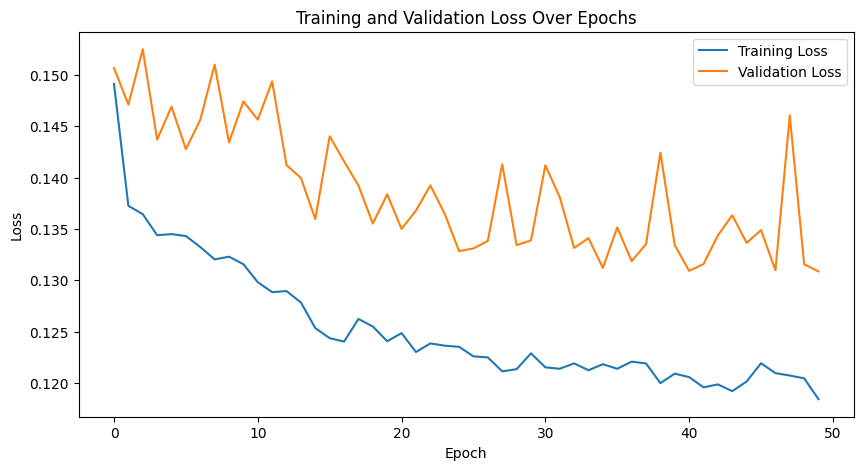

In [152]:
plot_errors(train_losses, val_losses)

In [153]:
def objective(trial):
    # Define the model architecture with hyperparameters suggested by Optuna
    n_units = trial.suggest_int("n_units", 4, 32)  # Number of units in the hidden layer
    dropout_rate = trial.suggest_float("dropout_rate", 0.0, 0.8)  # Dropout rate
    lr = trial.suggest_loguniform("lr", 1e-4, 1e-1)  # Learning rate
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-6, 1e-3)  # Weight decay

    # Define the model
    model = nn.Sequential(
        nn.Linear(X.shape[1], n_units),
        nn.ReLU(),
        nn.Dropout(dropout_rate),
        nn.Linear(n_units, 1),
        nn.Sigmoid()
    )

    # Define loss function and optimizer
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Set the number of epochs
    num_epochs = 10  # Adjust as needed for tuning

    # Training and validation phases for each epoch
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        for batch in train_loader:
            features, labels = batch
            labels = labels.view(-1, 1)  # Ensure labels shape matches the output shape

            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        # Calculate average training loss
        avg_train_loss = train_loss / len(train_loader)

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                features, labels = batch
                labels = labels.view(-1, 1)  # Ensure labels shape matches the output shape

                outputs = model(features)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        # Calculate average validation loss
        avg_val_loss = val_loss / len(val_loader)

    # Return the final average validation loss for this trial
    return avg_val_loss

# Run Optuna optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

# Print the results of the best trial
print("Best trial:", study.best_trial)
print("Best params:", study.best_trial.params)


[I 2024-10-06 22:12:13,383] A new study created in memory with name: no-name-31852c8b-9d7f-4f03-bd04-62e4e0c11e8b
[I 2024-10-06 22:12:26,033] Trial 0 finished with value: 0.14489749319787415 and parameters: {'n_units': 15, 'dropout_rate': 0.01712779304965242, 'lr': 0.0003823901686333567, 'weight_decay': 0.00013369780514277686}. Best is trial 0 with value: 0.14489749319787415.
[I 2024-10-06 22:12:39,501] Trial 1 finished with value: 0.14461701757644255 and parameters: {'n_units': 23, 'dropout_rate': 0.7345172519334362, 'lr': 0.001264037845360091, 'weight_decay': 0.000932056550084816}. Best is trial 1 with value: 0.14461701757644255.
[I 2024-10-06 22:12:52,731] Trial 2 finished with value: 0.15883649720006998 and parameters: {'n_units': 4, 'dropout_rate': 0.674159067453473, 'lr': 0.016819644126656524, 'weight_decay': 2.820529983914881e-06}. Best is trial 1 with value: 0.14461701757644255.
[I 2024-10-06 22:13:05,277] Trial 3 finished with value: 0.1395264945234677 and parameters: {'n_unit

Best trial: FrozenTrial(number=37, state=TrialState.COMPLETE, values=[0.12949650386954437], datetime_start=datetime.datetime(2024, 10, 6, 22, 20, 28, 688265), datetime_complete=datetime.datetime(2024, 10, 6, 22, 20, 42, 636534), params={'n_units': 25, 'dropout_rate': 0.015840712952531366, 'lr': 0.0081673087675269, 'weight_decay': 1.528549777471994e-06}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_units': IntDistribution(high=32, log=False, low=4, step=1), 'dropout_rate': FloatDistribution(high=0.8, log=False, low=0.0, step=None), 'lr': FloatDistribution(high=0.1, log=True, low=0.0001, step=None), 'weight_decay': FloatDistribution(high=0.001, log=True, low=1e-06, step=None)}, trial_id=37, value=None)
Best params: {'n_units': 25, 'dropout_rate': 0.015840712952531366, 'lr': 0.0081673087675269, 'weight_decay': 1.528549777471994e-06}


In [161]:
from sklearn.metrics import log_loss

# Assuming you have found the best parameters
best_params = study.best_trial.params
n_units = best_params["n_units"]
dropout_rate = best_params["dropout_rate"]
lr = best_params["lr"]
weight_decay = best_params["weight_decay"]  # Retrieve weight decay from the best parameters

# Define the model with the best parameters
model = nn.Sequential(
    nn.Linear(X.shape[1], n_units),
    nn.ReLU(),
    nn.Dropout(dropout_rate),
    nn.Linear(n_units, 1),
    nn.Sigmoid()
)

# Define the loss function and optimizer, including weight_decay
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)  # Add weight_decay here

# Track train and test losses
train_losses = []
test_losses = []
log_losses = []  # For tracking log loss on the validation set
num_epochs = 50

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    for data in train_loader:  # Changed to train_loader
        features, labels = data
        labels = labels.view(-1, 1)  # Ensure labels shape matches the output shape
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation phase for test loss
    model.eval()
    test_loss = 0.0
    all_outputs = []
    all_labels = []
    with torch.no_grad():
        for data in val_loader:  # Changed to val_loader
            features, labels = data
            labels = labels.view(-1, 1)  # Ensure labels shape matches the output shape
            outputs = model(features)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            
            # Collect outputs and labels for log loss calculation
            all_outputs.extend(outputs.cpu().numpy().flatten())  # Ensure outputs are flattened
            all_labels.extend(labels.cpu().numpy().flatten())   # Ensure labels are flattened
    
    avg_test_loss = test_loss / len(val_loader)
    test_losses.append(avg_test_loss)

    # Calculate log loss on validation set for the current epoch
    log_loss_value = log_loss(np.array(all_labels), np.array(all_outputs))
    log_losses.append(log_loss_value)

    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss}, Test Loss: {avg_test_loss}, Log Loss: {log_loss_value}")
# print out the average log loss
print(f"Average Log Loss: {np.mean(log_losses)}")

Epoch [1/50], Training Loss: 0.1378125669787602, Test Loss: 0.1461615516075452, Log Loss: 0.1461769784300254
Epoch [2/50], Training Loss: 0.1302347897534107, Test Loss: 0.14183828807471477, Log Loss: 0.1418747682526727
Epoch [3/50], Training Loss: 0.12625146544406954, Test Loss: 0.14073945551956044, Log Loss: 0.14077350290341925
Epoch [4/50], Training Loss: 0.12196584214526966, Test Loss: 0.13601467503600875, Log Loss: 0.13605314687106812
Epoch [5/50], Training Loss: 0.12046342660111467, Test Loss: 0.13606601632164636, Log Loss: 0.1361037829799852
Epoch [6/50], Training Loss: 0.12108680653447959, Test Loss: 0.13641120793265896, Log Loss: 0.1364368907759979
Epoch [7/50], Training Loss: 0.1198459021598226, Test Loss: 0.1332684820647643, Log Loss: 0.13330657252078304
Epoch [8/50], Training Loss: 0.11903353983871473, Test Loss: 0.13286032559055094, Log Loss: 0.1328861878700404
Epoch [9/50], Training Loss: 0.1181528823824568, Test Loss: 0.13373689227746374, Log Loss: 0.13377277026178136
Epo

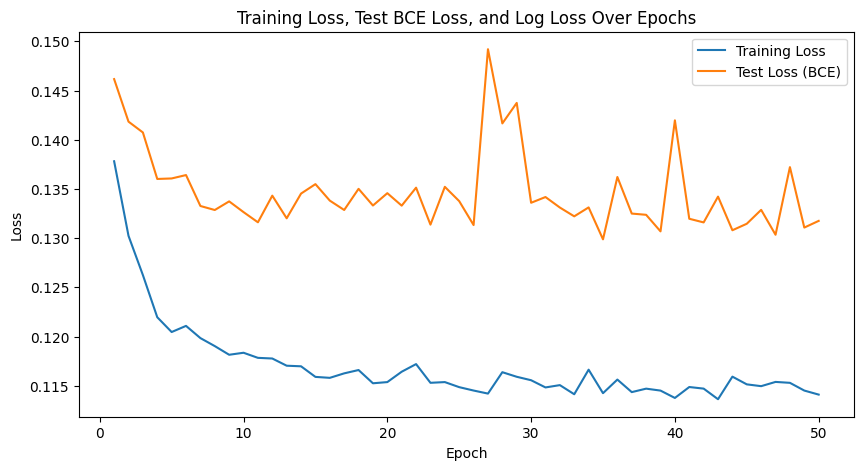

In [162]:
# Plot the training and test loss over epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss (BCE)')
#plt.plot(range(1, num_epochs + 1), log_losses, label='Log Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss, Test BCE Loss, and Log Loss Over Epochs')
plt.legend()
plt.show()

### update weights and biases
- Trains a model for 20 epochs, manually updating the weights and biases of the first layer at each step, instead of relying on a built-in optimizer.
- Calculates and prints the average loss for each epoch.
- Shows a more granular control over the training process, as you’re directly manipulating the model parameters based on computed gradients.

In [163]:
# Assuming an optimizer is defined (like Adam)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for data in train_loader:  # Changed dataloader to train_loader for consistency
        features, labels = data
        labels = labels.view(-1, 1)  # Ensure correct shape

        # Forward pass
        outputs = model(features)
        loss = criterion(outputs, labels)

        # Backward pass and optimization step
        optimizer.zero_grad()  # Reset gradients
        loss.backward()
        optimizer.step()  # Update all model parameters automatically
        
        # Accumulate the loss
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss}")

# print out the average log loss
print(f"Average Log Loss: {np.mean(avg_loss)}")

Epoch [1/20], Loss: 0.11593164504510606
Epoch [2/20], Loss: 0.11448631365500697
Epoch [3/20], Loss: 0.1141224961160883
Epoch [4/20], Loss: 0.11384227493293479
Epoch [5/20], Loss: 0.11489037486687484
Epoch [6/20], Loss: 0.1140221728149606
Epoch [7/20], Loss: 0.11510823153178217
Epoch [8/20], Loss: 0.11670705346130059
Epoch [9/20], Loss: 0.11394732341988152
Epoch [10/20], Loss: 0.11557578384706585
Epoch [11/20], Loss: 0.11496278072536995
Epoch [12/20], Loss: 0.11531178583698273
Epoch [13/20], Loss: 0.11451903664805961
Epoch [14/20], Loss: 0.1140839995350272
Epoch [15/20], Loss: 0.11444201485400934
Epoch [16/20], Loss: 0.11590996303201062
Epoch [17/20], Loss: 0.11470926868410229
Epoch [18/20], Loss: 0.11386583090089715
Epoch [19/20], Loss: 0.11430910689815982
Epoch [20/20], Loss: 0.11333366632009488
Average Log Loss: 0.11333366632009488


In [164]:
# Step 1: Convert X_final_test to tensor and create DataLoader for the test set
test_features = torch.tensor(X_final_test.to_numpy()).float()
test_dataset = TensorDataset(test_features)  # If you don't have labels, you can use just features
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# Step 2: Set model to evaluation mode and make predictions
model.eval()
predictions = []

with torch.no_grad():
    for data in test_loader:
        features = data[0]  # Extract features from the dataset
        outputs = model(features)
        predictions.extend(outputs.cpu().numpy())  # Collect predictions as numpy array

# Step 3: Convert predictions to numpy array and add to DataFrame
predictions = np.array(predictions).flatten()

In [166]:
X0 = filtered_data[["d", "r2", "min_MAF", "diff_MAF", "log10_distance", "error"]]
y0 = filtered_data["error"]
# Split the data into train and test using the same random_state and test_size as before
_, X0_test, _, _ = train_test_split(
    X0, y0, test_size=0.25, random_state=42, stratify=y
)

In [144]:
X0_test['NN_model1_pred'] = predictions
X0_test

,d,r2,min_MAF,log10distance_intxn_minMAF,log10distance_intxn_r2,log10distance_intxn_diffMAF,NN_model1_pred
3328,1.0,0.001,0.0010,0.001716,0.001716,0.240584,0.410276
14002,1.0,0.057,0.1561,0.385769,0.140864,0.122823,0.023045
8269,0.2,0.033,0.0845,0.410408,0.160278,1.510983,0.209222
6710,1.0,0.002,0.4076,0.902770,0.004430,0.000000,0.002378
11897,1.0,0.068,0.0765,0.202600,0.180088,0.763522,0.067113
...,...,...,...,...,...,...,...
10914,1.0,1.000,0.3728,0.703284,1.886491,0.000000,0.000321
5080,1.0,0.613,0.1491,0.408115,1.677899,0.152462,0.021634
2519,1.0,0.230,0.0497,0.234775,1.086485,1.117663,0.071788
12044,1.0,0.037,0.0298,0.088122,0.109414,1.190540,0.071688


In [165]:
X0_test['NN_model2_pred'] = predictions
X0_test

,d,r2,min_MAF,diff_MAF,log10distance_intxn_minMAF,log10_distance,NN_model2_pred
3328,1.0,0.001,0.0010,0.1402,0.001716,1.716003,0.150594
14002,1.0,0.057,0.1561,0.0497,0.385769,2.471292,0.005875
8269,0.2,0.033,0.0845,0.3111,0.410408,4.856904,0.157272
6710,1.0,0.002,0.4076,0.0000,0.902770,2.214844,0.000543
11897,1.0,0.068,0.0765,0.2883,0.202600,2.648360,0.019813
...,...,...,...,...,...,...,...
10914,1.0,1.000,0.3728,0.0000,0.703284,1.886491,0.000029
5080,1.0,0.613,0.1491,0.0557,0.408115,2.737193,0.003667
2519,1.0,0.230,0.0497,0.2366,0.234775,4.723850,0.115894
12044,1.0,0.037,0.0298,0.4026,0.088122,2.957128,0.033122


In [145]:
# Save the model's state dictionary
model_path = "/home/scarlett/github/Python/ipython_notebook/Coding/nn_model1"  # Replace 'model_name' with your desired file name
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")


Model saved to /home/scarlett/github/Python/ipython_notebook/Coding/nn_model1


In [146]:
# Define the model architecture (the same as when you trained it)
model = nn.Sequential(
    nn.Linear(X.shape[1], n_units),  # Replace 'n_units' with the appropriate size
    nn.ReLU(),
    nn.Dropout(dropout_rate),       # Replace 'dropout_rate' with the appropriate value
    nn.Linear(n_units, 1),
    nn.Sigmoid()
)

# Load the model's state dictionary
model.load_state_dict(torch.load(model_path))
model.eval()  # Set the model to evaluation mode
print("Model loaded and ready for predictions.")


Model loaded and ready for predictions.
